In [4]:
import sys
!{sys.executable} -m pip install psycopg2-binary pycountry pyproj fiona shapely
!{sys.executable} -m pip install geopandas

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/8b/fa/cec4ab1f4c64ee7e311de9f582982904bdb0ab9ee93e03fbe1b748e334c4/psycopg2_binary-2.9.7-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 17.4 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Set plot theme

sns.set_theme(context='paper', style='whitegrid', palette='deep')

In [5]:
# Create SQL Engine Connection to local postgres database

from sqlalchemy import create_engine, text as sqlText
connection_str = os.getenv('DATABASE_URL')
print(connection_str)

engine = create_engine(connection_str)
con = engine.connect()

postgresql://postgres:example@db:5432/postgres?sslmode=disable


In [8]:
df = pd.read_sql_query(sqlText('SELECT * from "Entry"'), con)

In [5]:
# drug_name can include a list separated by "|", here the first entry is extratcted

df['drug_name'] = df['drug_name'].fillna('<NA>')
df['full_drug_names'] = df['drug_name']
df['drug_name'] = df['drug_name'].map(lambda x: x.split('|')[0])


In [6]:
df['drug_role'] = df['drug_role'].fillna('<NA>')
df['legacy_search_term'] = df['legacy_search_term'].fillna('<NA>')


##### IMPORTANT ####
#### Filter for ALL Dataframes ####

df_no_filter = df.copy()

# df = df[df['legacy_search_term'] != '<NA>']
df = df[df['drug_name'] != '<NA>']
df = df[~df['drug_role'].isin(['minimal', 'not included', 'rescue medication'])]

# df = df[df['repurpose']] # only repurpose studies

In [7]:
# number of studies for each drug grouped by drug_role

df2 = df_no_filter[df_no_filter['drug_name'] != '<NA>']

pvt_roles = pd.crosstab(df2['drug_name'], df2['drug_role'])
pvt_roles.to_csv('pvt/roles.csv')

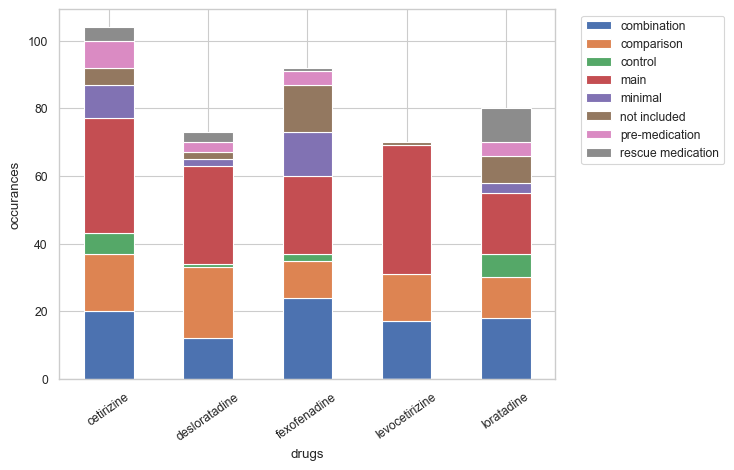

In [8]:
pvt_roles.plot(kind='bar', stacked=True)

plt.xlabel('drugs')
plt.ylabel('occurances')
plt.xticks(rotation=35)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('roles.pdf', bbox_inches='tight')
plt.show()

In [9]:
# number of studies for usecase grouped by drug_name

pvt_usecase = pd.crosstab(df['usecase'], [df['repurpose'], df['drug_name']], margins=True).sort_values(by = 'All', ascending=False).drop(index='All', columns='All')

# Flatten MultiIndex Columns
pvt_usecase.columns = ["{}_{}".format(search_term, 'repurpose' if repurpose else 'classic') for repurpose, search_term in pvt_usecase.columns]

pvt_usecase.to_csv('pvt/usecase.csv')


In [10]:
# Generate color palette to differanciate between repurpose and classic indication by color

repurpose_length = len([col for col in pvt_usecase.columns if 'repurpose' in col])

paletteBlue = sns.color_palette("blend:#5d5dfc,#5ddcfc", n_colors=repurpose_length)
paletteRed = sns.color_palette("blend:#6b232f,#b84256", n_colors=len(pvt_usecase.columns) - repurpose_length)

combined_palette = np.concatenate((paletteBlue.as_hex(), paletteRed.as_hex()))

(0.0, 18.0)

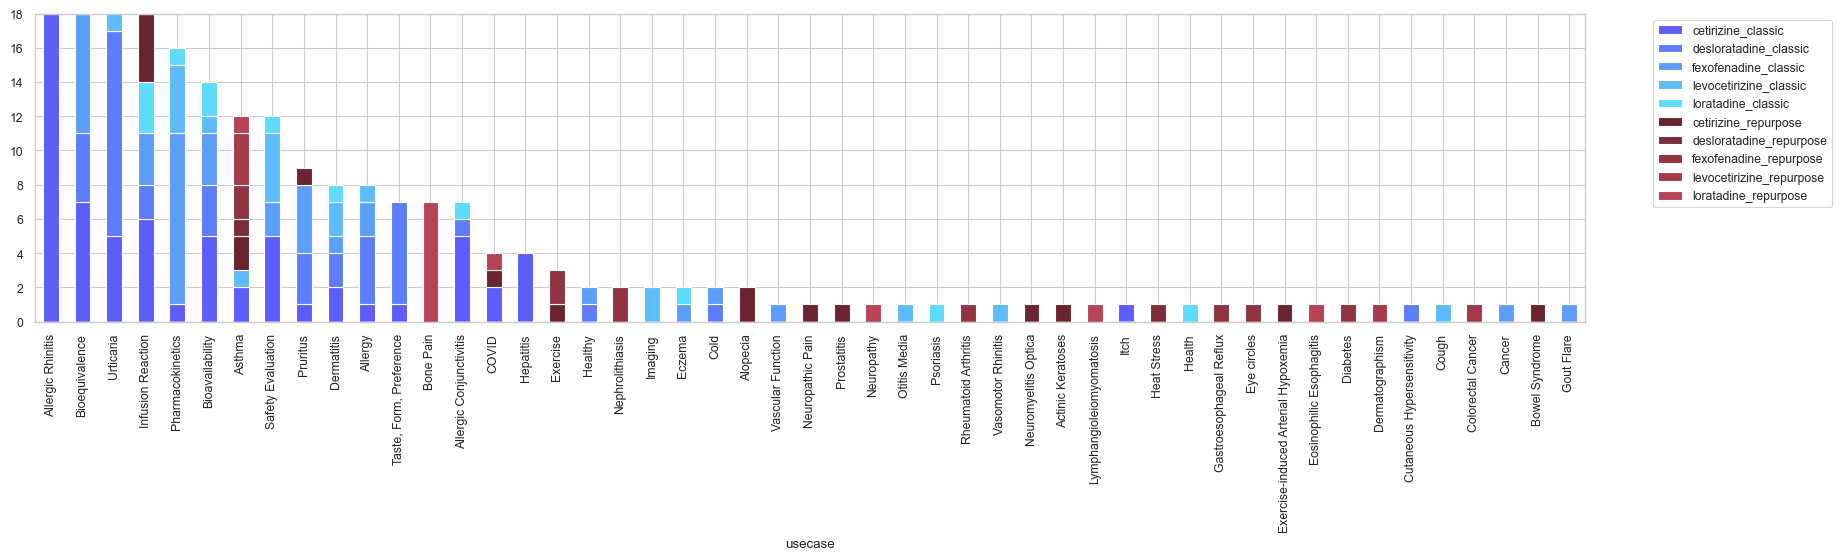

In [11]:
pvt_usecase.plot(kind="bar", stacked=True, figsize=(20, 4), color=combined_palette)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim(top=18)

In [12]:
# Transform values to dates

df['StudyFirstPostDate'] = pd.to_datetime(df['StudyFirstPostDate'])
df['StartDate'] = pd.to_datetime(df['StartDate'])

In [9]:
## Number of studies per year with regards to "StartDate" ###

pvt_timeline_start_date = df.pivot_table(index=pd.Grouper(key='StartDate', freq='y'), columns='drug_name', values='id', aggfunc='count', fill_value=0)

# Format date to only year string
pvt_timeline_start_date.index = pvt_timeline_start_date.index.map(lambda e: e.strftime("%Y"))
pvt_timeline_start_date.index.name = 'year'

pvt_timeline_start_date.to_csv('pvt/timeline_start_date.csv')


## Number of studies per year with regards to "StudyFirstPostDate" ###

pvt_timeline_first_post_date = df.pivot_table(index=pd.Grouper(key='StudyFirstPostDate', freq='y'), columns='drug_name', values='id', aggfunc='count', fill_value=0)

# Format date to only year string
pvt_timeline_first_post_date.index = pvt_timeline_first_post_date.index.map(lambda e: e.strftime("%Y"))
pvt_timeline_first_post_date.index.name = 'year'

pvt_timeline_first_post_date.to_csv('pvt/timeline_first_post_date.csv')


### Lag Data ###

## Get data from database
sqlLagYearsQuery = open('sql/lagYears.sql', 'r').read()

print(sqlLagYearsQuery)
df_lag_years = pd.read_sql(sqlText(sqlLagYearsQuery), con)
df_lag_years['year'] = df_lag_years['year'].astype(int)



TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

<Axes: title={'center': 'timeline of trials with posting lag'}, xlabel='year'>

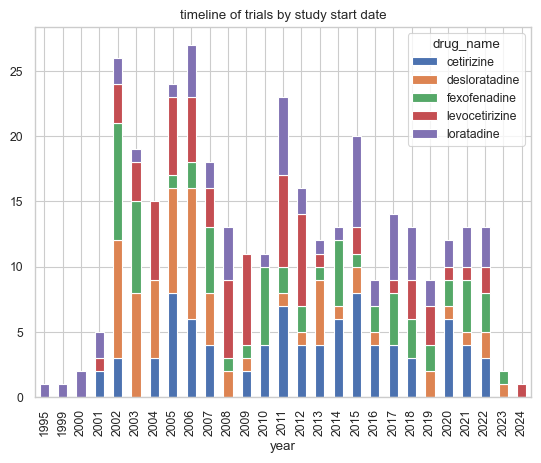

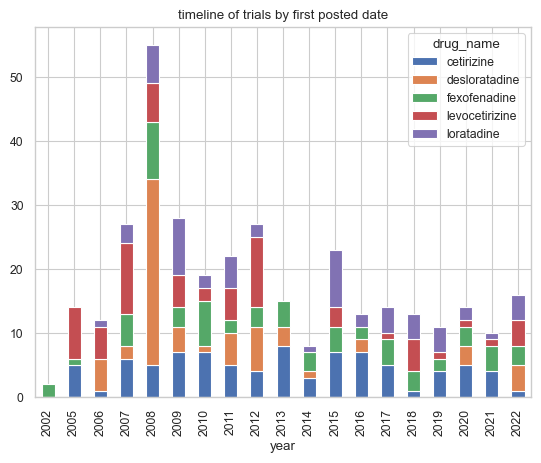

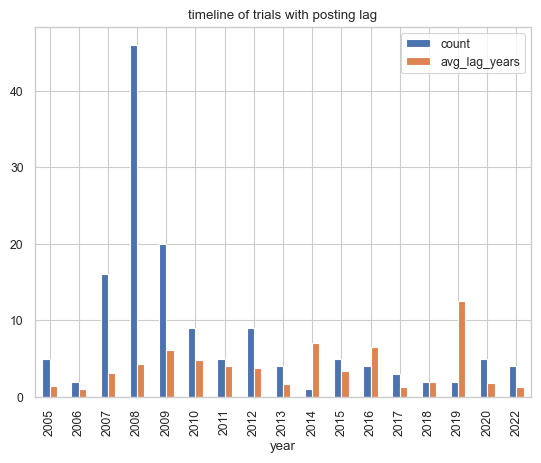

In [14]:
pvt_timeline_start_date.plot(kind='bar', stacked=True, title="timeline of trials by study start date")
pvt_timeline_first_post_date.plot(kind='bar', stacked=True, title="timeline of trials by first posted date")
df_lag_years.plot(kind='bar', x='year', title="timeline of trials with posting lag")

In [15]:

## Number of trials for each age category grouped by drug_name, NORMALIZED ##


# Those are lists in database, need to be joined
df['AgeCategoriesStr'] = df.AgeCategories.map('|'.join)

pvt_age = pd.crosstab(df['drug_name'], df['AgeCategoriesStr'], normalize='index')

pvt_age.to_csv('pvt/age.csv')

pvt_age

AgeCategoriesStr,Adult,Adult|Older Adult,Child,Child|Adult,Child|Adult|Older Adult
drug_name,,,,,
cetirizine,0.294118,0.364706,0.117647,0.082353,0.141176
desloratadine,0.151515,0.424242,0.212121,0.000000,0.212121
fexofenadine,0.312500,0.453125,0.046875,0.046875,0.140625
levocetirizine,0.304348,0.347826,0.144928,0.000000,0.202899
loratadine,0.254237,0.491525,0.050847,0.016949,0.186441


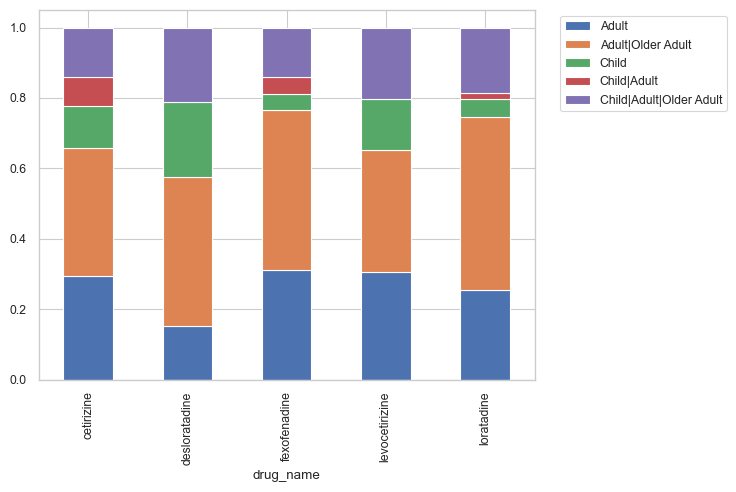

In [16]:
pvt_age.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [17]:
## Number of trials for each study status grouped by drug_name, NORMALIZED ##

pvt_status = pd.crosstab([df['drug_name']], df['OverallStatus'], normalize='index')
pvt_status.to_csv('pvt/status.csv')
pvt_status

OverallStatus,"Active, not recruiting",Completed,Enrolling by invitation,Not yet recruiting,Recruiting,Suspended,Terminated,Unknown status,Withdrawn
drug_name,,,,,,,,,
cetirizine,0.023529,0.776471,0.011765,0.011765,0.023529,0.000000,0.094118,0.047059,0.011765
desloratadine,0.015152,0.848485,0.000000,0.015152,0.030303,0.015152,0.030303,0.045455,0.000000
fexofenadine,0.031250,0.750000,0.000000,0.031250,0.093750,0.000000,0.046875,0.046875,0.000000
levocetirizine,0.000000,0.840580,0.000000,0.014493,0.086957,0.000000,0.028986,0.028986,0.000000
loratadine,0.000000,0.762712,0.000000,0.050847,0.033898,0.000000,0.067797,0.050847,0.033898


<Axes: xlabel='drug_name'>

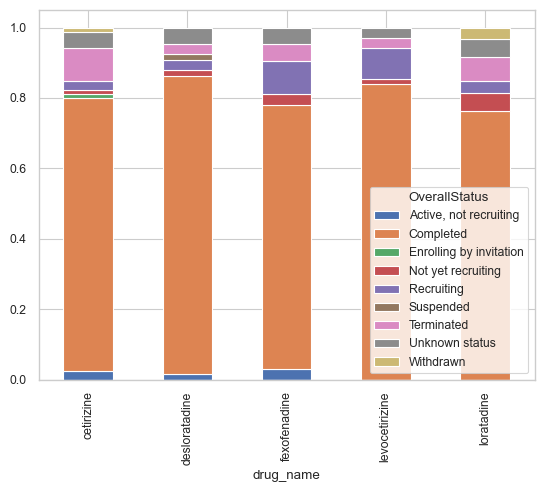

In [18]:
pvt_status.plot.bar(stacked=True)

In [19]:
## Number of trials for each gender grouped by drug_name, NORMALIZED ##

pvt_gender = pd.crosstab(df['drug_name'], df['Gender'], normalize='index')
pvt_gender.to_csv('pvt/gender.csv')

print(pd.crosstab(df['drug_name'], df['Gender'], margins=True, margins_name='Total'))

pvt_gender

Gender          All  Female  Male  Total
drug_name                               
cetirizine       76       1     6     83
desloratadine    63       0     3     66
fexofenadine     58       0     6     64
levocetirizine   59       0     9     68
loratadine       55       1     3     59
Total           311       2    27    340


Gender,All,Female,Male
drug_name,,,
cetirizine,0.915663,0.012048,0.072289
desloratadine,0.954545,0.000000,0.045455
fexofenadine,0.906250,0.000000,0.093750
levocetirizine,0.867647,0.000000,0.132353
loratadine,0.932203,0.016949,0.050847


<Axes: xlabel='drug_name'>

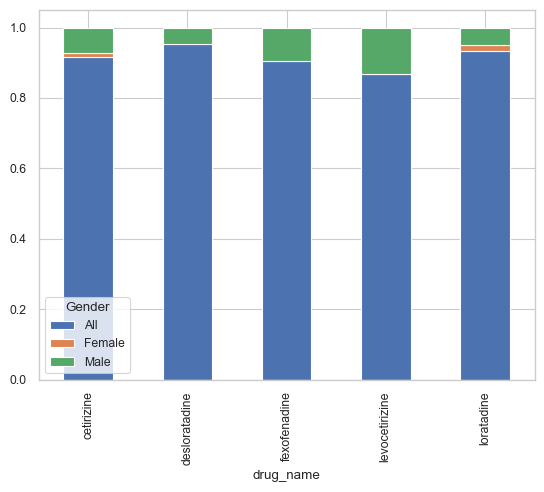

In [20]:
pvt_gender.plot.bar(stacked=True)

<Axes: xlabel='drug_name,DesignAllocation'>

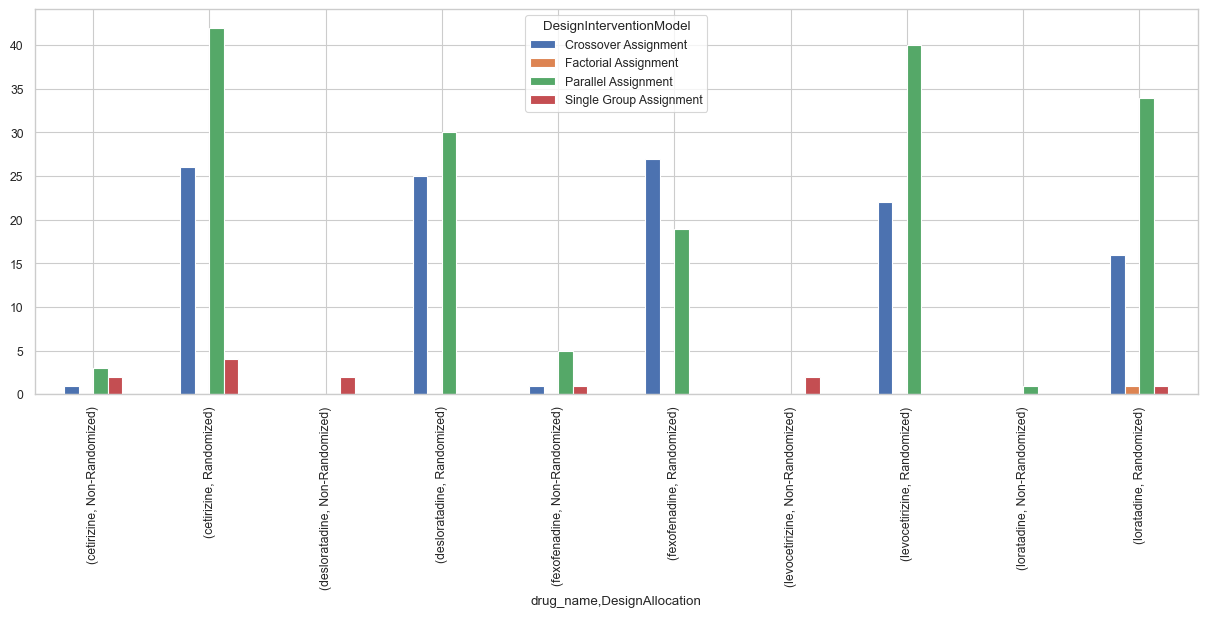

In [21]:
## Number of trials for each intervention model grouped by drug_name and allocation design ##
# Not yet saved as csv, therefore not in prism

df_filter = df[(df['StudyType'] == 'Interventional') & (df['StudyType'] != "N/A") & (df['DesignAllocation'] != 'N/A')]

pvt_allocation = pd.crosstab([df_filter['drug_name'], df_filter['DesignAllocation']], df_filter['DesignInterventionModel'])
pvt_allocation.plot(kind='bar', figsize=(15, 5))

In [10]:
### Get location data from database

sql_locations_query = open('sql/studyLocations.sql', 'r').read()
print(sql_locations_query)
df_countries = pd.read_sql_query(sqlText(sql_locations_query), con)

-- Get Study location overview similar to the one on CT
-- https://clinicaltrials.gov/ct2/results/map?term=Cetirizine+OR+Levocetirizine+OR+Fexofenadine+OR+Loratadine+OR+Desloratadine&map=
SELECT country, count(*) cou, sum(c) from (
	SELECT e.id, e."NCTId", l.country, count(*) c from "LocationOnEntries" le
	JOIN "Location" l ON l.id = le."locationId"
	JOIN "Entry" e ON e.id = le."entryId"
	-- WHERE e.repurpose
	GROUP BY e.id, l.country
	ORDER BY "NCTId"
) d
GROUP By country
ORDER BY cou DESC


In [17]:
# Import geopandas worlddata
import geopandas as gp
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_178/389839934.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [18]:
import pycountry

# Map countries in databsae to iso_a3 codes

df_countries['iso_a3'] = df_countries['country'].map(
    lambda c: pycountry.countries.search_fuzzy(c)[0].alpha_3)

#df_countries.to_csv('./df_countries.csv')

# https://geopandas.org/en/stable/docs/user_guide/mapping.html
# merge geometry data with database data
merged_data = world.merge(df_countries, on='iso_a3', how='left')

## Plot world map with data

fig, ax = plt.subplots(1, 1, figsize=(15 * 3, 7 * 3))

merged_data.plot(
    column='cou',
    legend=True,
    ax=ax,
    cmap='Blues',
    missing_kwds={
        "color": "#71717A",
        #"edgecolor": "red",
        #"hatch": "///",
        "label": "Missing values",
    },
    legend_kwds={
        #'label': "number of clinical trials",
        'orientation': "vertical",
        'shrink': 0.7
    })

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.axis('off')

fig.axes[1].tick_params(labelsize=25)

world.boundary.plot(ax=ax, color='black')



def print_label(x):
    
    cords = x['geometry'].representative_point().coords[:][0]
    count = int(x['cou'])
    if x['geometry'].area > 35:
        ax.annotate(
            text=count,
            #xy=x['geometry'].centroid.coords[0],
            xy=cords,
            ha='center',
            fontsize=20,
            #backgroundcolor="black",
            fontweight='bold',
            c='white' if count > 90 else 'black')
    else:
        return


# Add values as labels
annotation = merged_data[merged_data['cou'].notna()].apply(
    lambda x: print_label(x), axis=1)

fig.savefig('worldmap.pdf', transparent=True, bbox_inches='tight', pad_inches=1)

ModuleNotFoundError: No module named 'pycountry'

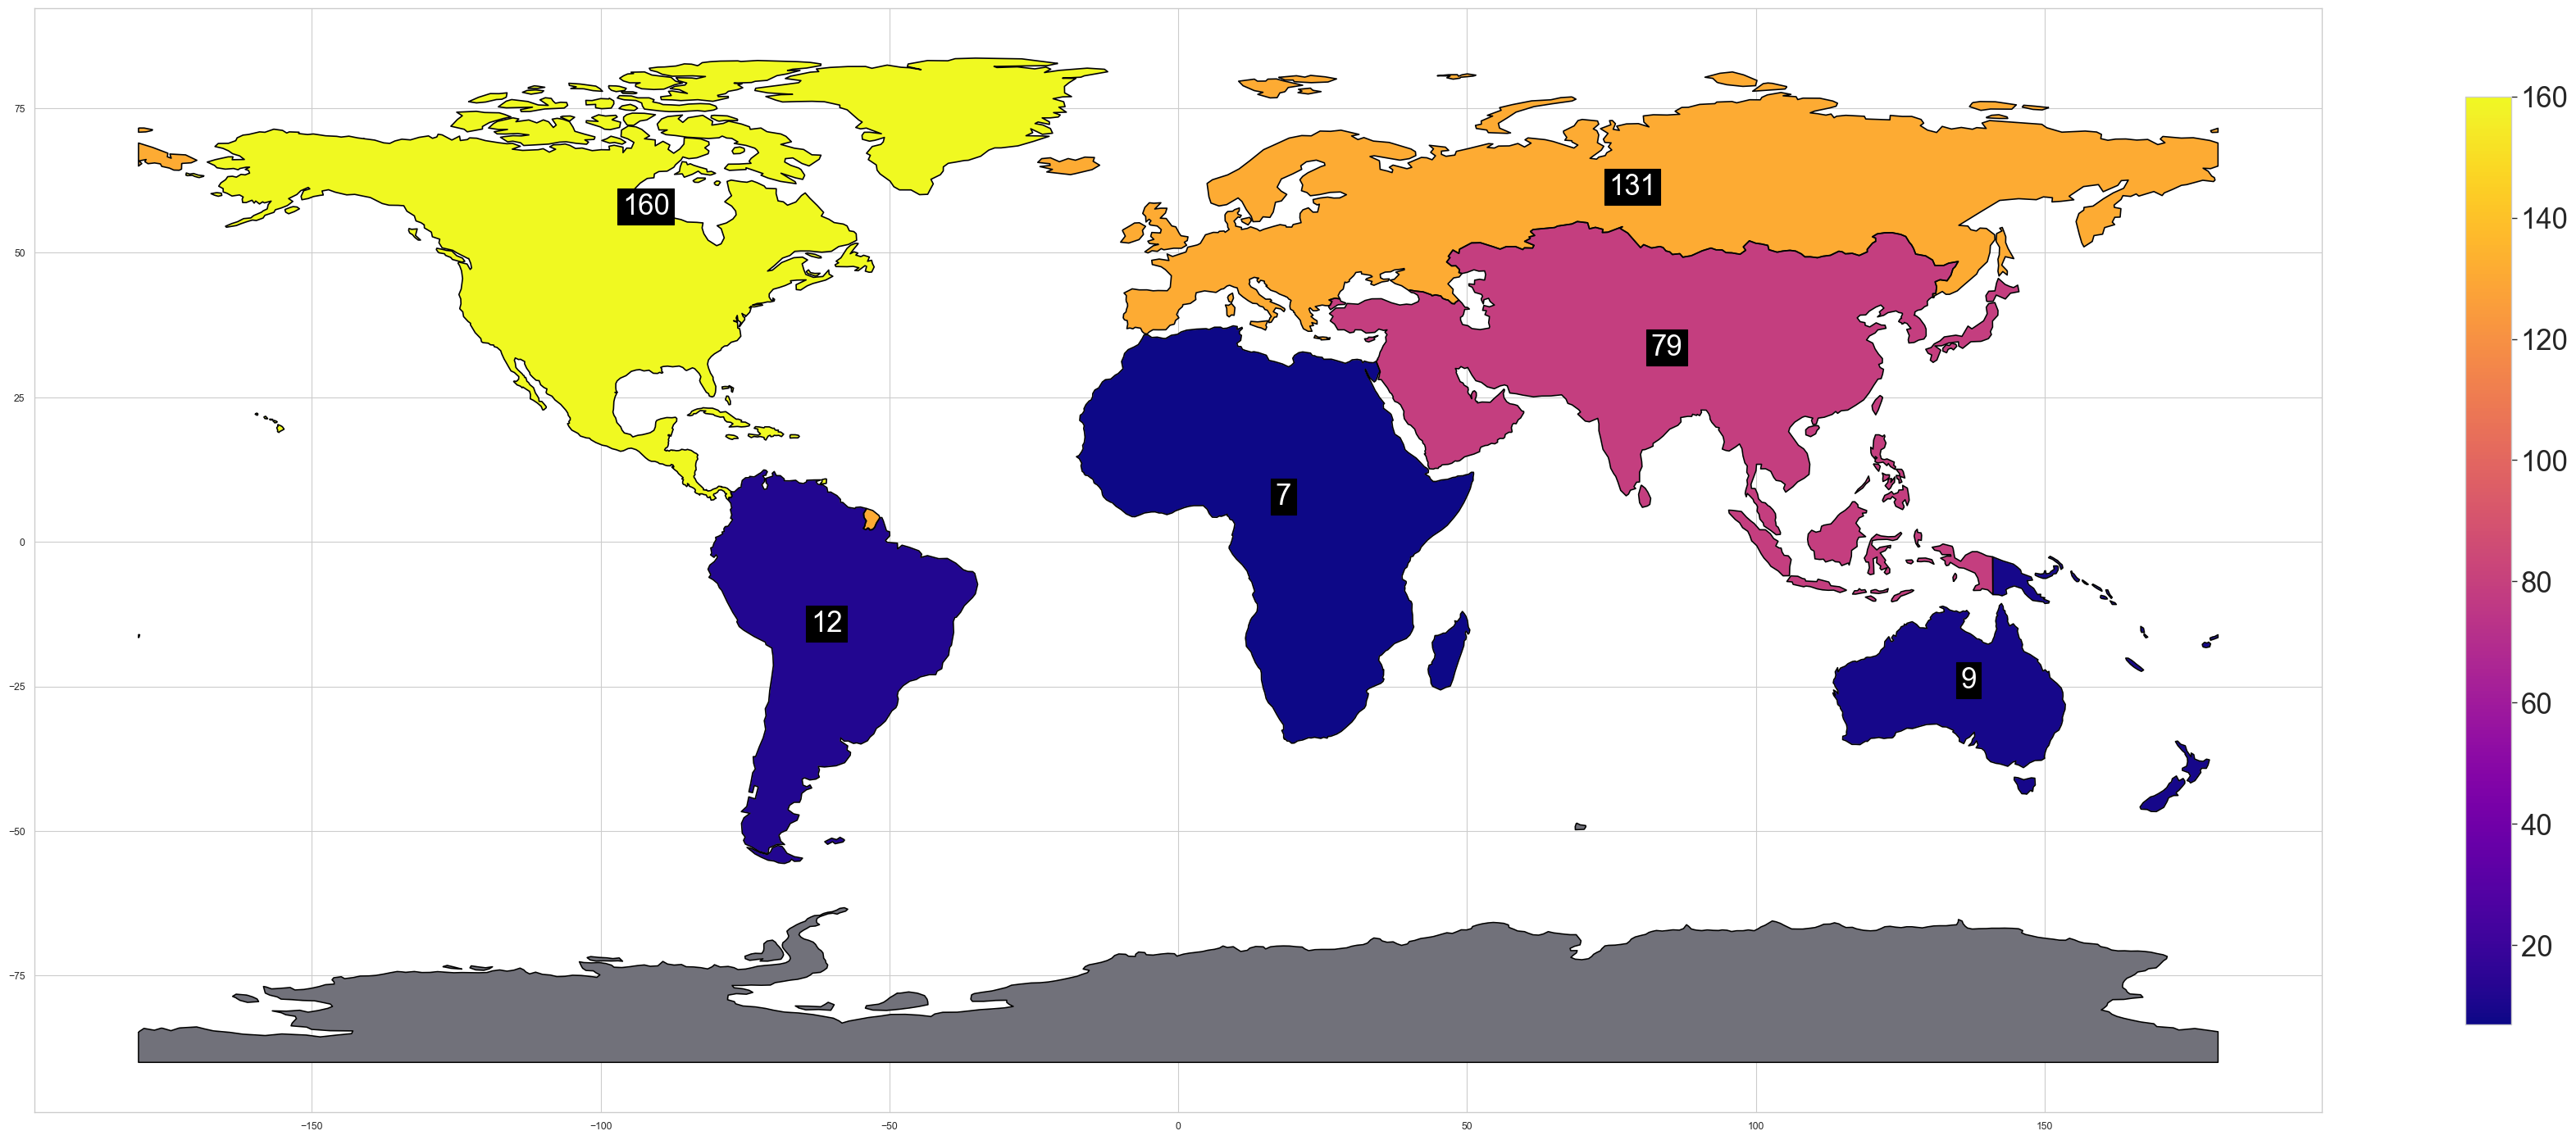

In [25]:
continents = merged_data.dissolve(by='continent', aggfunc={'cou': 'sum'})

# Set all 0 values to NA so they appear gray in map
continents.loc[continents['cou'] == 0, "cou"] = pd.NA

## Plot world map(continents) with data

fig, ax = plt.subplots(1, 1, figsize=(15 * 3, 7 * 3))

ax = continents.plot(
    column='cou',
    legend=True,
    ax=ax,
    cmap='plasma',
    missing_kwds={
        "color": "#71717A",
        #"edgecolor": "red",
        #"hatch": "///",
        "label": "Missing values",
    },
    legend_kwds={
        #'label': "number of clinical trials",
        'orientation': "vertical",
        'shrink': 0.7
    })

fig.axes[1].tick_params(labelsize=25)

continents.boundary.plot(ax=ax, color='black')

# Add values as labels
annotation = continents[continents['cou'].notna()].apply(
    lambda x: ax.annotate(text=int(x['cou']),
                          xy=x['geometry'].centroid.coords[0],
                          ha='center',
                          c="white",
                          fontsize=25,
                          backgroundcolor="black"),
    axis=1)

fig.savefig('worldmap_by_continents.pdf', transparent=True)

In [26]:
## Publication status of repurpose trials

df_repurpose = df[df['repurpose']]

pvt_publicationstatus_rp = pd.crosstab(df_repurpose['OverallStatus'], df_repurpose['publicationStatus'], normalize='index')



pvt_publicationstatus_rp.to_csv('pvt/publicationstatus_rp.csv')

pd.crosstab(df_repurpose['OverallStatus'], df_repurpose['publicationStatus'], margins=True)

publicationStatus,CT_RESULTS,NO_PUBLICATION_FOUND,PUBLISHED,All
OverallStatus,,,,
"Active, not recruiting",0,2,1,3
Completed,4,7,10,21
Not yet recruiting,0,4,0,4
Recruiting,0,7,0,7
Terminated,5,2,0,7
Unknown status,0,2,1,3
Withdrawn,0,1,0,1
All,9,25,12,46


<Axes: xlabel='OverallStatus'>

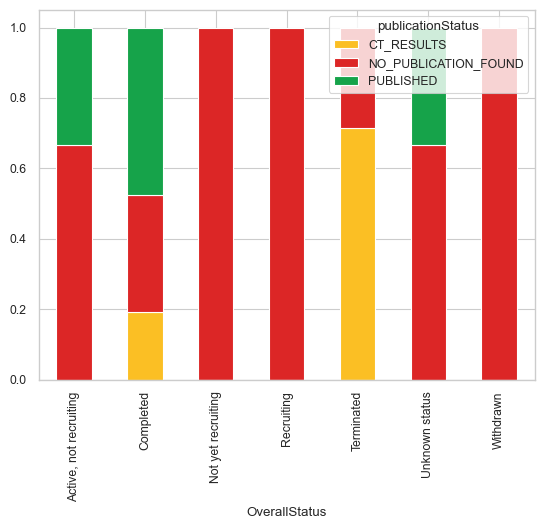

In [27]:
publicationStatusColors = ['#FBBF24', '#DC2626', '#16A34A', '#A8A29E']

pvt_publicationstatus_rp.plot.bar(stacked=True, color=publicationStatusColors)

<Axes: >

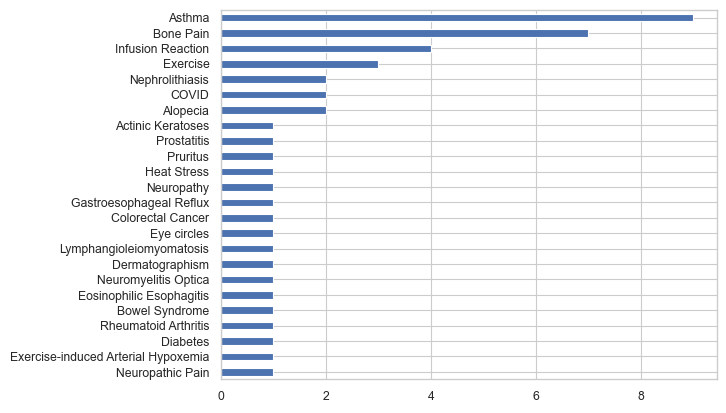

In [28]:
### Repurpose usecases

# [::-1] reverses list
pvt_usecase_rp = df_repurpose['usecase'].value_counts()[::-1]
pvt_usecase_rp.to_csv('pvt/usecase_rp.csv')


pvt_usecase_rp.plot.barh()